# Recitation 4
### 7.Oct.22
#### Mariana Martínez Aguilar

Today we are going to compare Newton's method to some quasi-Newtons methods. We are going to use the Rosenbrock function again but with different parameters.

### Rosenbrock function
In mathematical optimization, the Rosenbrock function is a non-convex function, introduced by Howard H. Rosenbrock in 1960, which is used as a performance test problem for optimization algorithms. It is also known as Rosenbrock's valley or Rosenbrock's banana function.

The global minimum is inside a long, narrow, parabolic shaped flat valley. To find the valley is trivial. To converge to the global minimum, however, is difficult.

The function originally has two parameters, $a$ and $b$ but in this case we will set $a = 1$ and $b = 5$. We know that the global optimum is found in $(a, a^2)$. The function in our case is:

$$ f(x, y) = (a - x)^2 + b(y - x^2)^2 = (1 - x)^2 + 5(y - x^2)^2. $$  

Plot the levels sets on this function on the square [-10,10] x [-10, 10]. Then for the square [-2.5, 2.5] x [-2.5, 2.5], plot this function in 3D, also plot its levels sets (this is a plot in 2D). For the contours plot the point $(a, a^2)$ as well. Use this colormap 'cet_linear_bmy_10_95_c78' .

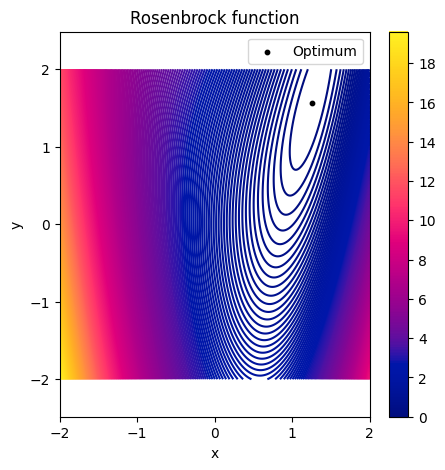

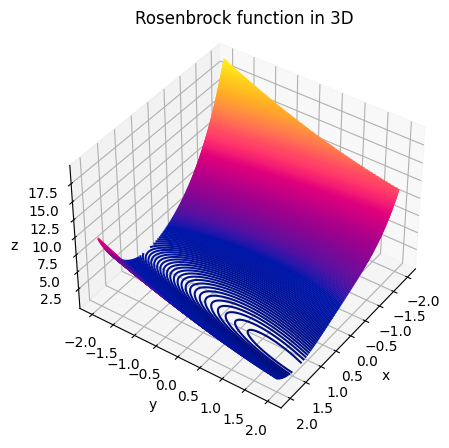

In [1]:
# First thing to do is to import numpy, matplotlib and colorcet

import numpy as np
import matplotlib.pyplot as plt
import colorcet as cc 
from numpy.linalg import norm, inv

a = 1.25
b = 0.25

def Ros(x, y):
    '''
    Rosenbrock function with parameters a = 1, b = 5
    '''
    return np.power(a-x,2) + b*np.power( np.subtract(y, np.power(x,2)), 2 )

# START PLOTTING

# 2D

Nx = 1000
Ny = 1000


# First plot

x, y = np.meshgrid( np.linspace(-2, 2, Nx), np.linspace(-2, 2, Ny) )
z = Ros(x, y)

# First plot

plt.figure(figsize = (5, 5))
im1 = plt.contour( x, y,z, levels = 250, 
                  cmap = 'cet_linear_bmy_10_95_c78') 
plt.axis('equal')
plt.title('Rosenbrock function') 
plt.xlabel('x')
plt.ylabel('y')
plt.scatter( a, a**2, marker = 'o', s = 10, c = 'black', 
           label = 'Optimum')
plt.legend()
plt.colorbar(im1)

# Contour in 3D
plt.figure(figsize = (5, 5))
ax = plt.axes( projection = '3d' )
ax.contour3D( x, y, z, 250, cmap = 'cet_linear_bmy_10_95_c78' )
plt.title('Rosenbrock function in 3D')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(40, 35)


### Steepest descent, Newton's method and quasi-Newton's method

Now define 3 functions to minimize the Rosenbrock function, one should use steepest descent, the other one should use Newton's method and the other one should use Broyden's method. What are the ingredients for each method?

In [2]:
# We need the gradient, backtracking, and the Hessian
from math import sqrt

def gradRosenbrock(x, y):
    '''
    Gradient of the Rosenbrock function
    '''
    grad = np.zeros((2, 1))
    grad[0] = -2*a + 4*b*x**3 - 4*b*x*y + 2*x
    grad[1] = 2*b*(y-x**2)
    return grad

def backTr(alpha, xn, yn, direction):
    '''
    Backtracking algorithm
    '''
    Fn = Ros(xn, yn) # function value of previous iteration
    xn_1 = xn + alpha*direction[0, 0]
    yn_1 = yn + alpha*direction[1, 0]
    Fn_1 = Ros(xn_1, yn_1) # function value of possible next iteration
    while Fn < Fn_1:
        alpha = alpha*beta
        xn_1 = xn + alpha*direction[0,0]
        yn_1 = yn + alpha*direction[1,0]
        Fn_1 = Ros(xn_1, yn_1) # Try again
    return alpha

def HessRosenbrock(x, y):
    '''
    Hessian of the Rosenbrock function
    '''
    Hess = np.zeros((2,2))
    Hess[0,0] = 12*b*x**2 - 4*b*y + 2 
    Hess[0,1] = -4*b*x # mixed partials
    Hess[1,0] = -4*b*x # mixed partials
    Hess[1,1] = 2*b
    return Hess

In [3]:
# Now we can define the 3 functions

##################################################
########### STEEPEST DESCENT
def steepDesc(x0, y0):
    '''
    Function that minimizes the Rosenbrock function
    in free space using the steepest descent direction
    '''
    xn_vec = [x0]
    yn_vec = [y0]
    F_vec = [Ros(x0, y0)]
    xn, yn = x0, y0
    i = 0
    d = -gradRosenbrock(xn, yn)
    while( norm(d) >= tol and i < maxIter ):
        d = -gradRosenbrock(xn, yn)
        alpha = backTr(alpha0, xn, yn, d)
        xn, yn = xn + alpha*d[0,0], yn + alpha*d[1, 0]
        xn_vec.append(xn)
        yn_vec.append(yn)
        F_vec.append(Ros(xn, yn))
        i += 1
    return (xn, yn), xn_vec, yn_vec, F_vec, i


##################################################
########### NEWTON'S METHOD

def newton(x0, y0):
    '''
    Function that minimizes the Rosenbrock function
    in free space using Newton's method
    '''
    xn_vec = [x0]
    yn_vec = [y0]
    F_vec = [Ros(x0, y0)]
    xn, yn = x0, y0
    i = 0
    g = -gradRosenbrock(xn, yn)
    while( norm(g) >= tol and i < maxIter ):
        Hess = HessRosenbrock(xn, yn) # In this method we do need the hessian
        g = gradRosenbrock(xn, yn)
        d = -inv(Hess)*g # Direction on which we are going to move
        alpha = backTr(alpha0, xn, yn, d)
        xn, yn = xn + alpha*d[0,0], yn + alpha*d[1, 0]
        xn_vec.append(xn)
        yn_vec.append(yn)
        F_vec.append(Ros(xn, yn))
        i += 1
    return (xn, yn), xn_vec, yn_vec, F_vec, i


##################################################
########### BROYDEN'S METHOD

def broyden(x0, y0, B0):
    '''
    Function that minimizes the Rosenbrock function
    in free space using Broyden's update to the
    Hessian (i.e. we don't compute the Hessian on
    each step)
    '''
    xn_vec = [x0]
    yn_vec = [y0]
    F_vec = [Ros(x0, y0)]
    xn, yn = x0, y0
    i = 0
    g = gradRosenbrock(xn, yn)
    sk = np.ones(g.shape)
    Bk = B0
    while( norm(g) >= tol and i < maxIter and norm(sk) >= tol ):
        d = -inv(Bk)@g # Direction on which we are going to move
        alpha = backTr(alpha0, xn, yn, d)
        xn, yn = xn + alpha*d[0,0], yn + alpha*d[1, 0]
        # Now we need to update the Hessian approximation using Broyden's formula
        # We need the parameters sk and yk (as in Nocedal or Griva)
        gnew = gradRosenbrock(xn, yn) # We need this to compute yk
        sk = alpha*d
        yk = gnew - g
        Bk = Bk + (1/(sk@sk.T))*(yk - Bk@sk)*sk.T # Broyden's formula
        xn_vec.append(xn)
        yn_vec.append(yn)
        F_vec.append(Ros(xn, yn))
        g = gnew
        i += 1
    return (xn, yn), xn_vec, yn_vec, F_vec, i


Set the starting point to (1.5, -1) and plot the different trajectories done by these methods. Plot the contours of the function with this colormap 'cet_linear_grey_10_95_c0'.




Values found with steepest 1.2499999999997575 1.5624999999984854
Optimal with Steepest 2.6508360471292336e-25
Number of iterations 402



Values found with Newton 1.2499999999998619 1.5625000000000917
Optimal with Newton 6.681356044382512e-26
Number of iterations 267



Values found with Broyden 1.4047619047619047 1.9642857142857137
Optimal with Newton 0.023971814727402643
Number of iterations 2


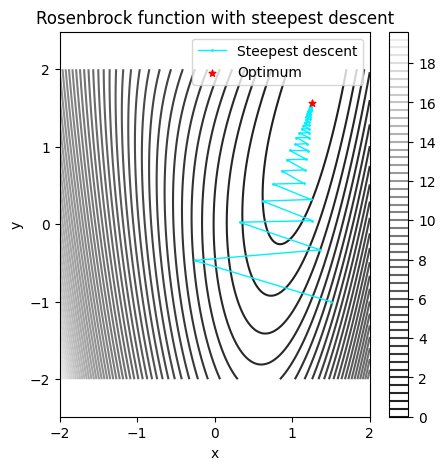

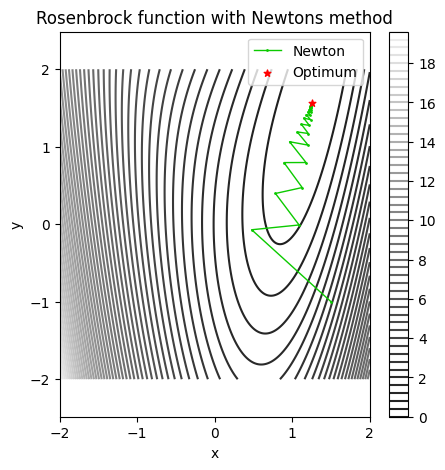

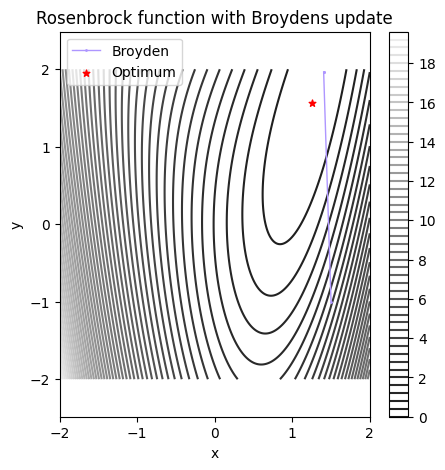

In [4]:
# We need to define the following parameters

maxIter = 1000
alpha0 = 1
beta = 0.8
tol = 1e-12
x0 = 1.5
y0 = -1
B0 = HessRosenbrock(x0, y0)

# Steepest descent
(xn_S, yn_S), xn_vec_S, yn_vec_S, F_vec_S, i_S = steepDesc(x0, y0)
print("\n\n\nValues found with steepest", xn_S, yn_S)
print("Optimal with Steepest", Ros(xn_S, yn_S))
print("Number of iterations", i_S)

# Newton

(xn_N, yn_N), xn_vec_N, yn_vec_N, F_vec_N, i_N = newton(x0, y0)
print("\n\n\nValues found with Newton", xn_N, yn_N)
print("Optimal with Newton", Ros(xn_N, yn_N))
print("Number of iterations", i_N)

# Broyden

(xn_B, yn_B), xn_vec_B, yn_vec_B, F_vec_B, i_B = broyden(x0, y0, B0)
print("\n\n\nValues found with Broyden", xn_B, yn_B)
print("Optimal with Newton", Ros(xn_B, yn_B))
print("Number of iterations", i_B)

# Plot the trajectories

plt.figure(figsize = (5, 5))
im2 = plt.contour( x, y,z, levels = 50, 
                  cmap = 'cet_linear_grey_10_95_c0') 
plt.axis('equal')
plt.title('Rosenbrock function with steepest descent') 
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xn_vec_S, yn_vec_S, marker = '.', markersize = 2, 
        linewidth = 1, c = "#00f0ff", label = "Steepest descent")
plt.scatter( a, a**2, marker = '*', s = 25, c = '#ff0000', 
           label = 'Optimum', zorder=3)
plt.legend()
plt.colorbar(im2)


plt.figure(figsize = (5, 5))
im3 = plt.contour( x, y,z, levels = 50, 
                  cmap = 'cet_linear_grey_10_95_c0') 
plt.axis('equal')
plt.title('Rosenbrock function with Newtons method') 
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xn_vec_N, yn_vec_N, marker = '.', markersize = 2, 
        linewidth = 1, c = '#0cca00', label = "Newton")
plt.scatter( a, a**2, marker = '*', s = 25, c = '#ff0000', 
           label = 'Optimum', zorder=3)
plt.legend()
plt.colorbar(im3)


plt.figure(figsize = (5, 5))
im4 = plt.contour( x, y,z, levels = 50, 
                  cmap = 'cet_linear_grey_10_95_c0') 
plt.axis('equal')
plt.title('Rosenbrock function with Broydens update') 
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xn_vec_B, yn_vec_B, marker = '.', markersize = 2, 
        linewidth = 1, c = "#ae96ff", label = "Broyden")
plt.scatter( a, a**2, marker = '*', s = 25, c = '#ff0000', 
           label = 'Optimum', zorder=3)
plt.legend()
plt.colorbar(im4)
